<a href="https://colab.research.google.com/github/koiryu/hello-world/blob/master/CNN%E5%BE%A9%E7%BF%92_kikagaku_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_lightning==1.9.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
torch.__version__, torchvision.__version__, pl.__version__

('1.13.1+cu116', '0.14.1+cu116', '1.9.4')

Baseline

In [ ]:
# 前処理
"""Tensor型：numpyのndarray型ととても似ており,ベクトル表現から行列表現,それらの演算といった機能が提供されている.
何が違うかというとTensor型はGPUを使用して演算等が可能である点"""

transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# 学習データセットの読込 : CIFAR10

train_val = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# train : val = 8 : 2
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(42)

# train と val を分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train), len(val), len(test)

(40000, 10000, 10000)

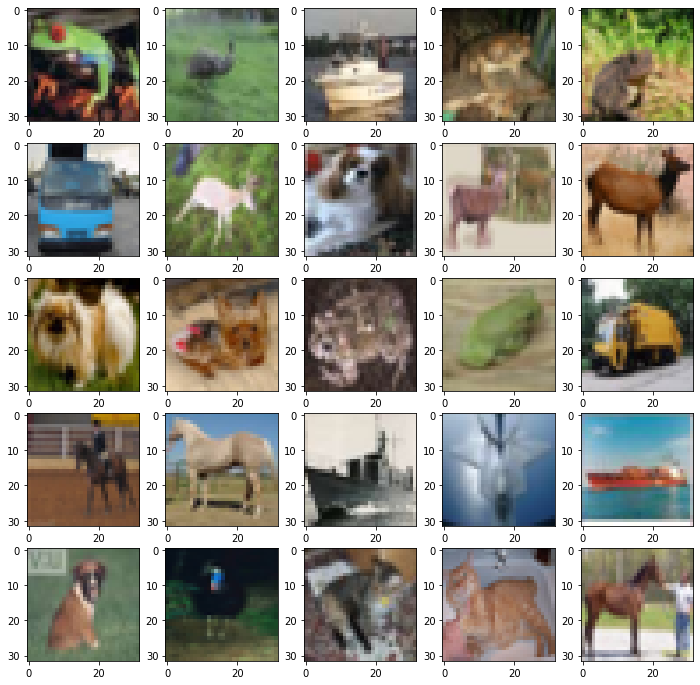

In [ ]:
# 画像の表示

plt.figure(figsize=(12, 12))
for i in range(25):
  # 画像を (height, width, channel) の順に変換
  img = np.transpose(train[i][0].numpy(), (1, 2, 0))
  plt.subplot(5, 5, i+1)
  plt.imshow(img)

In [ ]:
class TrainNet(pl.LightningModule):

  # デコレータ：関数やクラスの前後に特定の処理を追加できる機能です。関数やクラス宣言の前に@デコレータ名を記述することで実現
  # @pl.data_loader
  def train_dataloader(self):
    return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)

  def training_step(self, batch, batch_nb):
    x, t = batch
    y = self.forward(x)
    loss = self.lossfun(y, t)
    y_label = torch.argmax(y, dim=1)
    acc = torch.sum(t == y_label) *1.0 / len(t)
    results = {'loss': loss, 'acc': acc}
    return results

    # self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    # self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
    # return loss

In [ ]:
class ValidationNet(pl.LightningModule):

  # デコレータ：関数やクラスの前後に特定の処理を追加できる機能です。関数やクラス宣言の前に@デコレータ名を記述することで実現
  # @pl.data_loader
  def validation_dataloader(self):
    return torch.utils.data.DataLoader(val, self.batch_size, shuffle=True)

  # 検証データに対する各イテレーションごとの結果
  def validation_step(self, batch, batch_nb):
    x, t = batch
    y = self.forward(x)
    loss = self.lossfun(y, t)
    # torch.argmax: 最大値に対する要素番号を求める。第二引数dimを指定すると、各軸に沿って最大値のインデックスが返ってくる。
    y_label = torch.argmax(y, dim=1)
    # 値が True となる個数の総和を要素数で割る
    acc = torch.sum(t == y_label) * 1.0 / len(t)
    results = {'val_loss': loss, 'val_acc': acc}
    return results
    
    # self.log('val_batch_loss', loss, on_step=False, on_epoch=True)
    # self.log('val_bath_acc', acc, on_step=False, on_epoch=True)
    # return loss
  
  # エポック毎にその結果を集計
  def validation_end(self, outputs):
    # torch.stack : Concatenates a sequence of tensors along a new dimension.All tensors need to be of the same size.
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
    results = {'val_loss': avg_loss, 'val_acc': avg_acc}
    return results

In [ ]:
class TestNet(pl.LightningModule):

  def test_dataloader(self):
    return torch.utils.data.DataLoader(test, self.batch_size, shuffle=True)

  def test_step(self, batch, batch_nb):
    x, t = batch
    y = self.forward(x)
    loss = self.lossfun(y, t)
    y_label = torch.argmax(y, dim=1)
    acc = torch.sum(t == y_label) * 1.0 /len(t)
    results = {'test_loss': loss, 'test_acc': acc}
    return results
    
    # self.log('test_batch_loss', loss, on_step=False, on_epoch=True)
    # self.log('test_batch_acc', acc, on_step=False, on_epoch=True)
    # return loss

  def test_end(self, outputs):
    avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
    results = {'test_loss': avg_loss, 'test_acc': avg_acc}
    return results

In [ ]:
# 学習データ、検証データ、テストデータへの処理を継承したクラス
class Net(TrainNet, ValidationNet, TestNet):

  def __init__(self, input_size=784, hidden_size=100, output_size=10, batch_size=256):
    # super().__init__() : 基底クラス（継承元）のコンストラクタをオーバーライド。コンストラクタの上書きはsuper().__init__()
    super().__init__()
    self.batch_size = batch_size
    
    # 畳み込み層
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    
    # 全結合層
    self.fc1 = nn.Linear(128*4*4, 128)
    self.fc2 = nn.Linear(128, 10)

    # Batch Normalization
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128) 

  def lossfun(self, y, t):
    return F.cross_entropy(y, t)
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)
  
  def forward(self, x):
    # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
    
    # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
    
    # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
    
    # ch: 256 -> 512, size: 4 * 4 -> 2 * 2
    # x = self.conv4(x)
    # x = self.bn4(x)
    # x = F.relu(x)
    # x = F.max_pool2d(x, 2, 2)
    
    # 512 * 2 * 2 = 2048
    # x = x.view(-1, 2048)
    x = x.view(x.size(0), -1)
    
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    
    return x

In [ ]:
# 再現性の確保
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)

# モデル学習の準備
net = Net(batch_size=1024)

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min',
)

# 単一の GPU で学習
trainer = Trainer(gpus=1, max_epochs=50, callbacks=[early_stop_callback])

# モデルの学習
trainer.fit(net)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Param

Training: 0it [00:00, ?it/s]

RuntimeError: ignored

In [ ]:
# 検証データ&テストデータに対する結果
trainer.test()
trainer.callback_metrics